# Plot object features for different CSLs

In [1]:
from campa.tl import Experiment, FeatureExtractor, thresholded_count, thresholded_median
from campa.tl._features import _thresholded_mask
from campa_ana.constants import SOURCE_DIR
from pathlib import Path
from campa.pl import hex2rgb, plot_object_stats
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import seaborn as sns
import pandas as pd
from copy import deepcopy

Reading config from /Users/hannah.spitzer/projects/pelkmans/software_new/campa/config.ini


In [2]:
fig_dir = Path(SOURCE_DIR)/'figures'/'fig5'
os.makedirs(str(fig_dir), exist_ok=True)

In [3]:
exp = Experiment.from_dir('VAE_SBF2/CondVAE_siRNA-CC')
extrs = {data_dir: FeatureExtractor.from_adata(os.path.join(exp.full_path, 'aggregated/full_data', data_dir, 'features_seed3_annotation.h5ad')) 
    for data_dir in exp.data_params['data_dirs'][:-1]}

## explore area vs cajal body intensity

In [4]:
df = pd.concat([extr.adata.uns['object_stats'] for extr in list(extrs.values())], keys=list(extrs.keys()))
df = df.reset_index(level=0)
df = df.reset_index(drop=True)

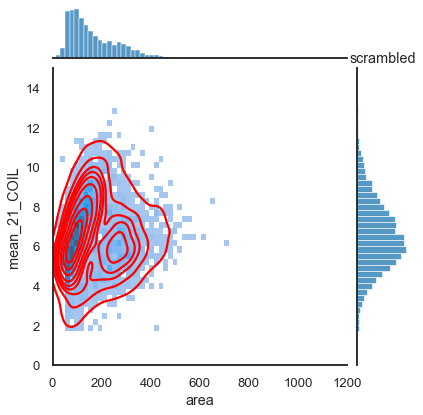

<Figure size 432x288 with 0 Axes>

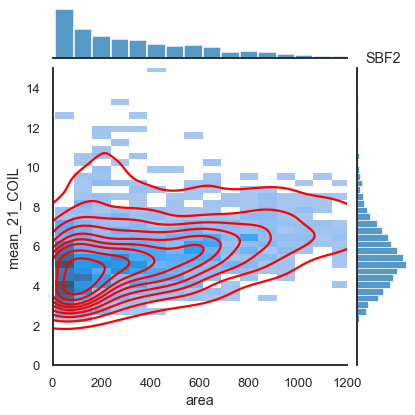

<Figure size 432x288 with 0 Axes>

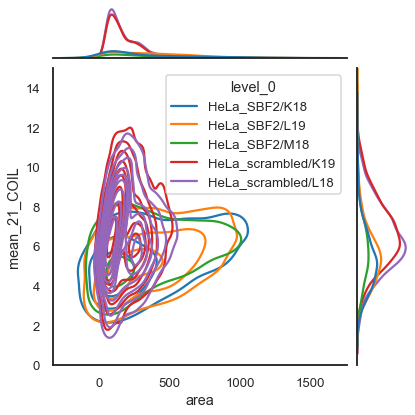

In [10]:
# Cajal bodies intensity vs size
cur_df = df[df['clustering'] == 'Cajal bodies']
# filter those objects with really large area
cur_df = cur_df[cur_df['area'] < np.quantile(cur_df['area'], 0.999)]
# filter ofjects with area < 10
cur_df = cur_df[cur_df['area'] > 10]
# filter objects with low intensity of COIL
cur_df = cur_df[(cur_df['mean_21_COIL'] > 5) | (cur_df['area'] > 50)]


g = sns.jointplot(data=cur_df[cur_df['level_0'].isin(['HeLa_scrambled/L18', 'HeLa_scrambled/K19'])], x="area", y="mean_21_COIL", ylim=[0,15], xlim=[0,1200], kind='hist')
g.plot_joint(sns.kdeplot, color="r")
plt.title('scrambled')
plt.figure()
g = sns.jointplot(data=cur_df[~cur_df['level_0'].isin(['HeLa_scrambled/L18', 'HeLa_scrambled/K19'])], x="area", y="mean_21_COIL", ylim=[0,15], xlim=[0,1200], kind='hist')
g.plot_joint(sns.kdeplot, color="r")
plt.title('SBF2')
plt.figure()
sns.jointplot(data=cur_df, x="area", y="mean_21_COIL", hue='level_0', ylim=[0,15], kind='kde')

## aggregate using additional thresholded

In [4]:
# aggregate object statistics, using additional thresholding
for extr in extrs.values():
    _ = extr.get_object_stats(area_threshold=10, agg=['median', thresholded_count, thresholded_median])
# combined adatas for plotting
adata_object_stats = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')

## Plot object stats with thresholded count + median
Maybe can find sth to filter them on?

- cajal bodies seem to be relatively small (for SBF2 cells) when there are many
- following experiments below, aggregate using thresholded_count which only counts large objects up to threshold % of total size.

In [23]:
adata_object_stats.obs[['siRNA','well_name']].value_counts()

siRNA      well_name
scrambled  L18          809
           K19          767
SBF2       L19          201
           K18          124
           M18          105
dtype: int64

In [19]:
agg_stats

,area_median|Antibody aggregates,area_median|Cajal bodies,area_median|Cell-cell contacts,area_median|Cytoplasm,area_median|ER (perinuclear),area_median|ER (peripheral),area_median|Focal adhesions,area_median|Golgi apparatus,area_median|HDAC3 foci,area_median|Mitochondria (peripheral),...,mean_21_NCL_thresholded_median|Nuclear periphery,mean_21_NCL_thresholded_median|Nuclear speckles,mean_21_NCL_thresholded_median|Nucleolus,mean_21_NCL_thresholded_median|Nucleoplasm,mean_21_NCL_thresholded_median|P-bodies,mean_21_NCL_thresholded_median|PML bodies,well_name,perturbation_duration,TR,siRNA
mapobject_id,,,,,,,,,,,,,,,,,,,,,
250343,285.0,114.0,29.5,32.0,49.0,0.0,24.0,2563.0,17.5,28.0,...,0.068445,0.113753,1.202327,0.142559,0.029103,1.364317,K19,normal,250.662301,scrambled
240689,0.0,719.0,19.0,19.0,17.0,12.0,22.0,4197.0,0.0,23.0,...,0.067582,0.107656,0.634490,0.124546,0.025643,0.094045,L18,normal,160.192453,scrambled
278843,0.0,33.5,20.0,36.0,29.0,0.0,20.0,824.5,0.0,26.0,...,0.233367,0.100295,0.649459,0.223291,0.029616,0.078222,L18,normal,213.811331,scrambled
227992,0.0,182.0,24.0,23.0,19.5,0.0,15.0,2069.0,0.0,0.0,...,0.084997,0.158455,0.746479,0.231652,0.052922,0.154519,L18,normal,266.543917,scrambled
336820,0.0,0.0,20.0,31.0,40.5,13.0,27.0,144.5,0.0,16.0,...,0.098878,0.104962,0.760229,0.075785,0.037934,0.117308,L18,normal,167.632968,scrambled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207172,0.0,40.0,28.5,22.5,19.0,21.0,29.0,16.5,17.0,26.0,...,0.044822,0.108599,1.261836,0.166011,0.027998,0.117342,K19,normal,208.982544,scrambled
253197,0.0,104.5,40.5,25.5,26.0,0.0,24.0,44.0,0.0,18.0,...,0.377074,0.108313,0.694842,0.129111,0.037449,0.090115,L18,normal,188.502667,scrambled
237614,0.0,38.0,15.5,24.5,28.5,16.0,26.0,37.0,14.0,25.0,...,0.118811,0.420041,2.103952,0.779691,0.026955,0.544542,K18,normal,149.521833,SBF2


In [15]:
agg_stats = adata_object_stats.obsm['object_stats_agg']
agg_stats.columns = pd.MultiIndex.from_tuples([tuple(i.split("|")) for i in agg_stats.columns])
agg_stats['siRNA'] = adata_object_stats.obs['siRNA']

In [19]:
sns.histplot(data=agg_stats, x=('count', 'Cajal bodies'), hue='siRNA')
plt.figure()
sns.scatterplot(data=agg_stats, x=('count', 'Cajal bodies'), y=('area_median', 'Cajal bodies'), hue='siRNA')

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

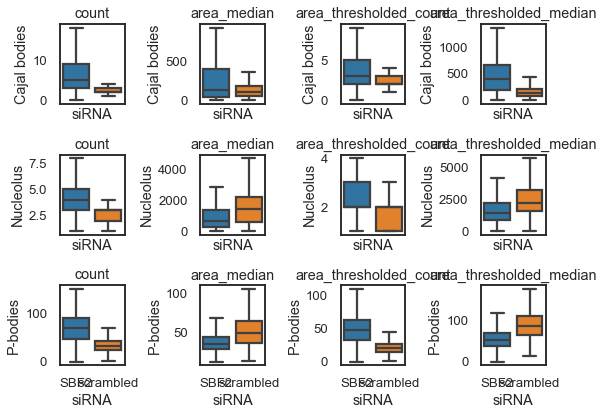

In [20]:
# areas < 10 filtered
plot_object_stats(adata_object_stats, 'siRNA', features=['count', 'area_median', 'area_thresholded_count', 'area_thresholded_median'], 
                  clusters=['Cajal bodies', 'Nucleolus', "P-bodies"], showfliers=False)



## Plot example cells showing need for filtering in the case of cajal bodies
### SBF2/K18

In [5]:
# get mpp data for SBF2 well
mpp_data = extrs['HeLa_SBF2/K18'].mpp_data
object_stats = extrs['HeLa_SBF2/K18'].adata.uns['object_stats']


Text(0.5, 1.0, 'Nucleous size in K18')

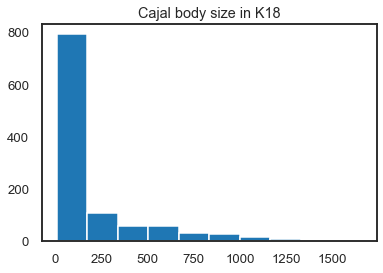

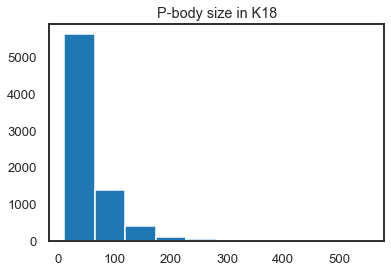

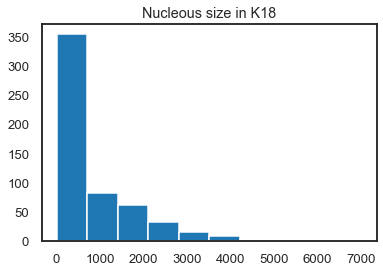

In [8]:
# cajal body size dist has long tail. Others don't
mask = (object_stats['clustering'] == 'Cajal bodies') & (object_stats['area'] > 10)
plt.hist(object_stats[mask]['area'])
plt.title('Cajal body size in K18')

plt.figure()
mask = (object_stats['clustering'] == 'P-bodies') & (object_stats['area'] > 10)
plt.hist(object_stats[mask]['area'])
plt.title('P-body size in K18')

plt.figure()
mask = (object_stats['clustering'] == 'Nucleolus') & (object_stats['area'] > 10)
plt.hist(object_stats[mask]['area'])
plt.title('Nucleous size in K18')

In [27]:
from skimage.measure import label, regionprops
from campa.pl import annotate_img

sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

num_cells = 5
cur_adata = adata_object_stats[adata_object_stats.obs['well_name'] == 'K18']
selected_cells = cur_adata.obs['mapobject_id'].iloc[np.random.choice(range(len(cur_adata)), num_cells, replace=False)]

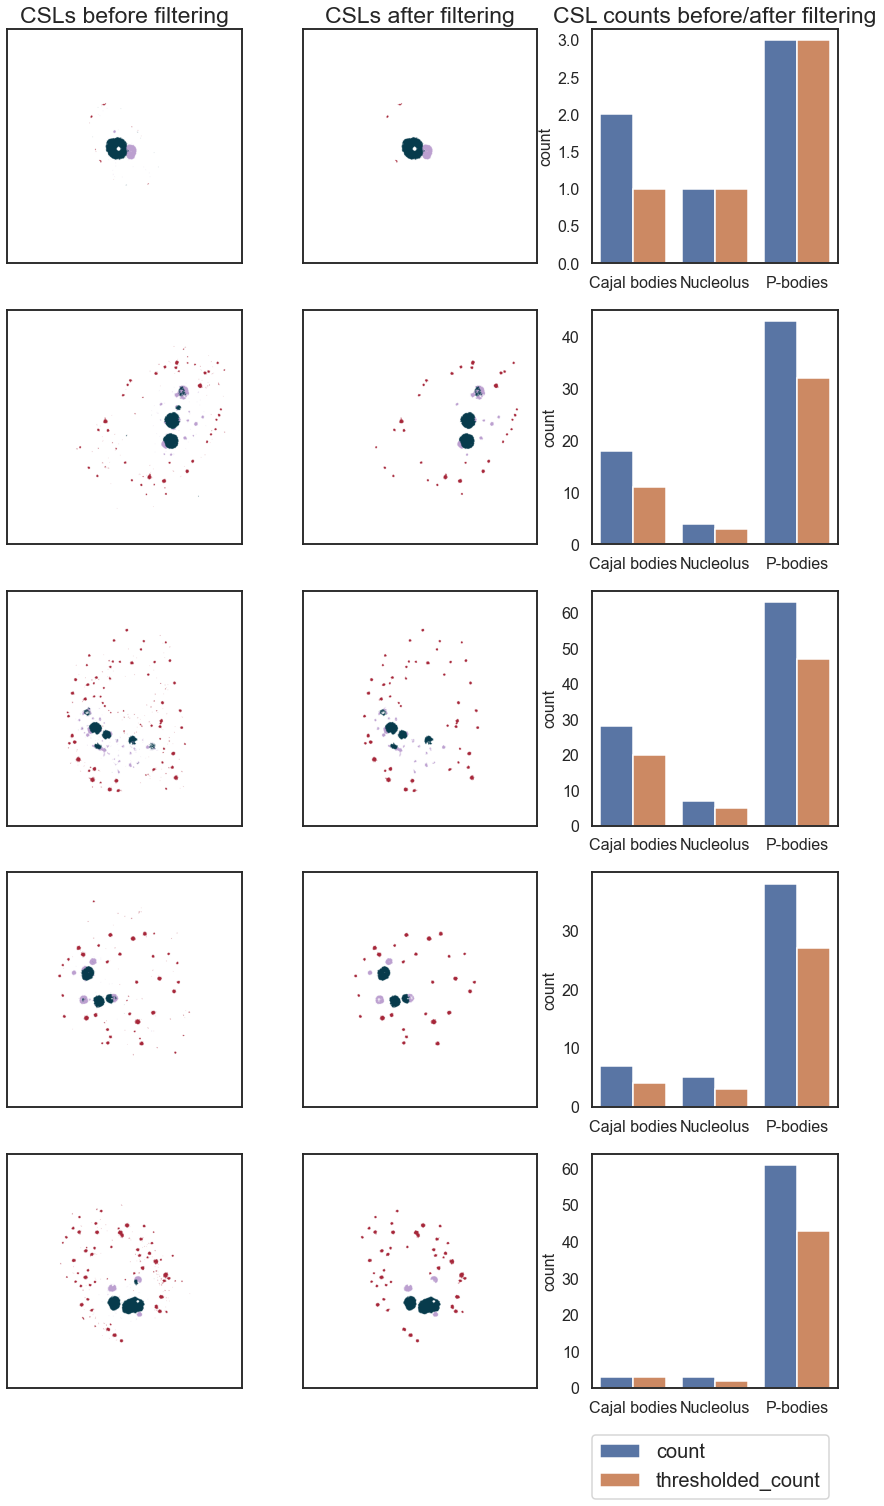

In [37]:
img_size = 750

# plot cajal bodies, nucleolus, and p-bodies
fig, axes = plt.subplots(num_cells,3, figsize=(15, num_cells*5), squeeze=False)
for i, obj_id in enumerate(selected_cells):
    cluster_img_colored = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation', 'color':True}, img_size=img_size)
    cluster_img = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation'}, img_size=img_size)
    cluster_img_masked = np.copy(cluster_img_colored)
    cluster_img_masked[~np.in1d(cluster_img, ['Cajal bodies', 'Nucleolus', 'P-bodies']).reshape(img_size,img_size)] = [255,255,255]

    # get thresholded information
    counts = {}
    for cl in ['Cajal bodies', 'Nucleolus', 'P-bodies']:
        mask = (object_stats['mapobject_id'] == int(obj_id)) & (object_stats['clustering'] == cl) & (object_stats['area'] > 10)
        object_mask = _thresholded_mask(object_stats[mask]['area'], threshold=0.9)
        min_size = object_stats[mask]['area'][object_mask].min()
        counts[cl] = {'min_size': min_size, 'count': len(object_stats[mask]), 
            'thresholded_count': len(object_stats[mask]['area'][object_mask])}

    # build thresholded image
    # get label image for filtering small objects
    cluster_names = {n: i for i, n in enumerate(extr.clusters + [""])}
    # convert labels to numbers
    img = np.vectorize(cluster_names.__getitem__)(cluster_img[:, :, 0])
    label_img = label(img, background=len(extr.clusters), connectivity=2)

    thresh_cluster_img = np.full((img_size,img_size), fill_value="", dtype=object)
    # iterate over all regions in this image
    for region in regionprops(label_img, intensity_image=img[:,:,np.newaxis]):
        # filter out single pixel regions, they cause problems in elongation and circularity calculation
        if region.area > 1:
            # get cluster label for this region
            assert region.min_intensity[0] == region.max_intensity[0]
            c = int(region.min_intensity[0])
            cluster = (extr.clusters + [""])[c]
            for cl in ['Cajal bodies', 'Nucleolus', 'P-bodies']:
                if cluster == cl and region.area >= counts[cl]['min_size']:
                    # is a selected cluster
                    thresh_cluster_img[region.coords[:,0], region.coords[:,1]] = cl
    thresh_cluster_img_colored = annotate_img(thresh_cluster_img, extr.annotation, from_col='annotation', color=True)

    # plot
    axes[i,0].imshow(cluster_img_masked)
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,1].imshow(thresh_cluster_img_colored)
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

    df = pd.melt(pd.DataFrame(counts).T.reset_index(), id_vars='index', value_vars=['count', 'thresholded_count'])
    df = df.rename(columns={'index':'CSL', 'value': 'count'})
    sns.barplot(data=df, y='count', hue='variable', x='CSL', ax=axes[i,2])
    axes[i,2].legend_.remove()
    axes[i,2].set_xlabel('')
    axes[i,2].set_ylabel('count', fontsize=16)
    axes[i,2].tick_params(axis='both', which='major', labelsize=16)
   
axes[0,0].set_title('CSLs before filtering', fontsize=23)
axes[0,1].set_title('CSLs after filtering', fontsize=23)
axes[0,2].set_title('CSL counts before/after filtering', fontsize=23)

plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, prop={'size': 20})

plt.savefig(fig_dir/'suppl_example_cells_SBF2_K18.pdf', dpi=200, bbox_inches='tight')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

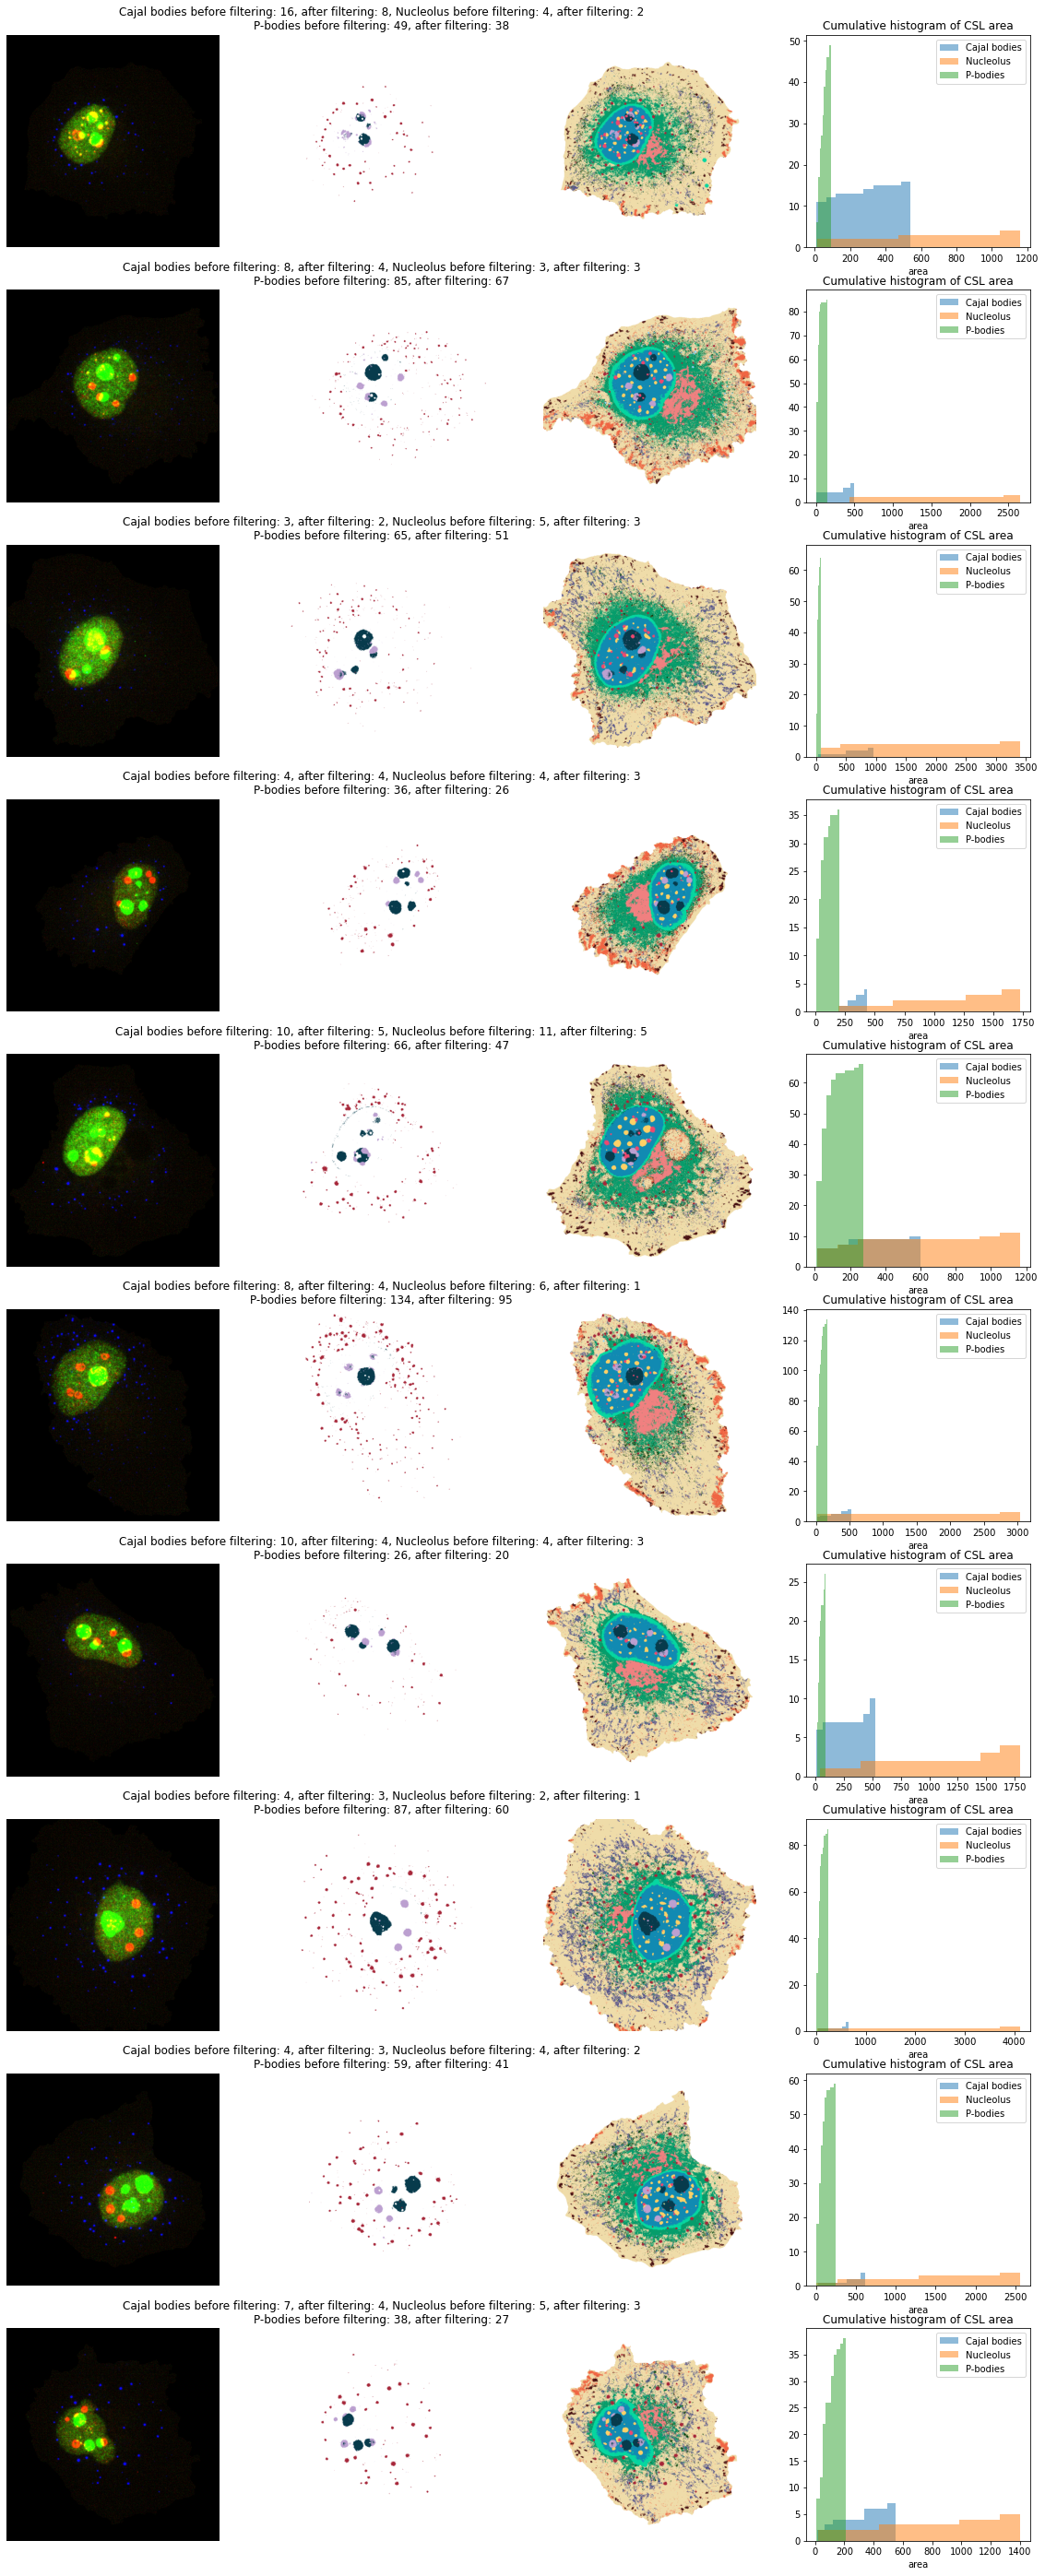

In [72]:
# OLD
# plot cajal bodies, nucleolus, and p-bodies
fig, axes = plt.subplots(num_cells,4, figsize=(20, num_cells*5), squeeze=False)
for i, obj_id in enumerate(selected_cells):
    intensity_img = mpp_data.get_object_img(int(obj_id), data='mpp', channel_ids=mpp_data.get_channel_ids(['21_COIL', '21_NCL', '22_DDX6']), img_size=750)
    cluster_img_colored = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation', 'color':True}, img_size=750)
    cluster_img = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation'}, img_size=750)
    cluster_img_masked = np.copy(cluster_img_colored)
    cluster_img_masked[~np.in1d(cluster_img, ['Cajal bodies', 'Nucleolus', 'P-bodies']).reshape(750,750)] = [255,255,255]
    axes[i,0].imshow(intensity_img)
    axes[i,0].axis('off')
    axes[i,1].imshow(cluster_img_masked)
    axes[i,1].axis('off')
    axes[i,2].imshow(cluster_img_colored)
    axes[i,2].axis('off')
    # plot histogram of sizes
    mask = (object_stats['mapobject_id'] == int(obj_id)) & (object_stats['clustering'] == 'Cajal bodies') & (object_stats['area'] > 10)
    title = f"Cajal bodies before filtering: {len(object_stats[mask]['area'])}, after filtering: {object_stats[mask]['area'].agg(thresholded_count)}"
    axes[i,3].set_title(f"Cumulative histogram of CSL area")
    axes[i,3].hist(object_stats[mask]['area'], cumulative=True, density=False, alpha=0.5, label='Cajal bodies')
    axes[i,3].set_xlabel('area')
    
    mask = (object_stats['mapobject_id'] == int(obj_id)) & (object_stats['clustering'] == 'Nucleolus') & (object_stats['area'] > 10)
    title += f", Nucleolus before filtering: {len(object_stats[mask]['area'])}, after filtering: {object_stats[mask]['area'].agg(thresholded_count)}"
    axes[i,3].hist(object_stats[mask]['area'], cumulative=True, density=False, alpha=0.5, label='Nucleolus')
    
    mask = (object_stats['mapobject_id'] == int(obj_id)) & (object_stats['clustering'] == 'P-bodies') & (object_stats['area'] > 10)
    title += f"\nP-bodies before filtering: {len(object_stats[mask]['area'])}, after filtering: {object_stats[mask]['area'].agg(thresholded_count)}"
    axes[i,3].hist(object_stats[mask]['area'], cumulative=True, density=False, alpha=0.5, label='P-bodies')
    axes[i,3].legend()
    
    axes[i,1].set_title(title)
plt.savefig(fig_dir/'suppl_example_cells_SBF2_K18.png', dpi=200, bbox_inches='tight')

### scrambled/K19

In [5]:
# get mpp data for SBF2 well
mpp_data = extrs['HeLa_scrambled/K19'].mpp_data
object_stats = extrs['HeLa_scrambled/K19'].adata.uns['object_stats']

Text(0.5, 1.0, 'Nucleous size in HeLa_scrambled/K19')

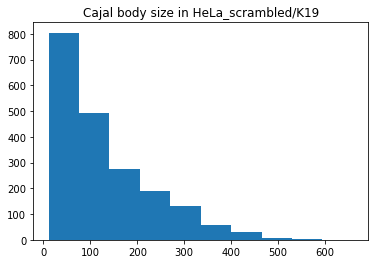

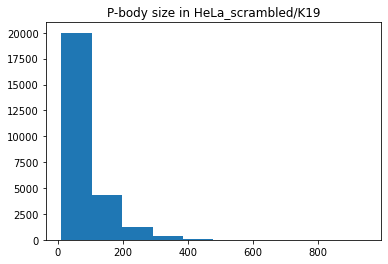

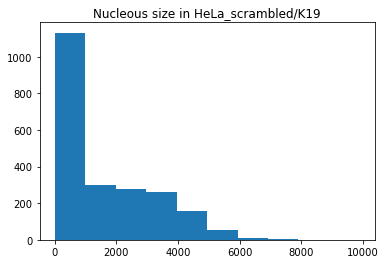

In [6]:
# cajal body size dist has long tail. Others don't
mask = (object_stats['clustering'] == 'Cajal bodies') & (object_stats['area'] > 10)
plt.hist(object_stats[mask]['area'])
plt.title('Cajal body size in HeLa_scrambled/K19')

plt.figure()
mask = (object_stats['clustering'] == 'P-bodies') & (object_stats['area'] > 10)
plt.hist(object_stats[mask]['area'])
plt.title('P-body size in HeLa_scrambled/K19')

plt.figure()
mask = (object_stats['clustering'] == 'Nucleolus') & (object_stats['area'] > 10)
plt.hist(object_stats[mask]['area'])
plt.title('Nucleous size in HeLa_scrambled/K19')

In [13]:
from skimage.measure import label, regionprops
from campa.pl import annotate_img

sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

num_cells = 5
cur_adata = adata_object_stats[adata_object_stats.obs['well_name'] == 'K19']
selected_cells = cur_adata.obs['mapobject_id'].iloc[np.random.choice(range(len(cur_adata)), num_cells, replace=False)]

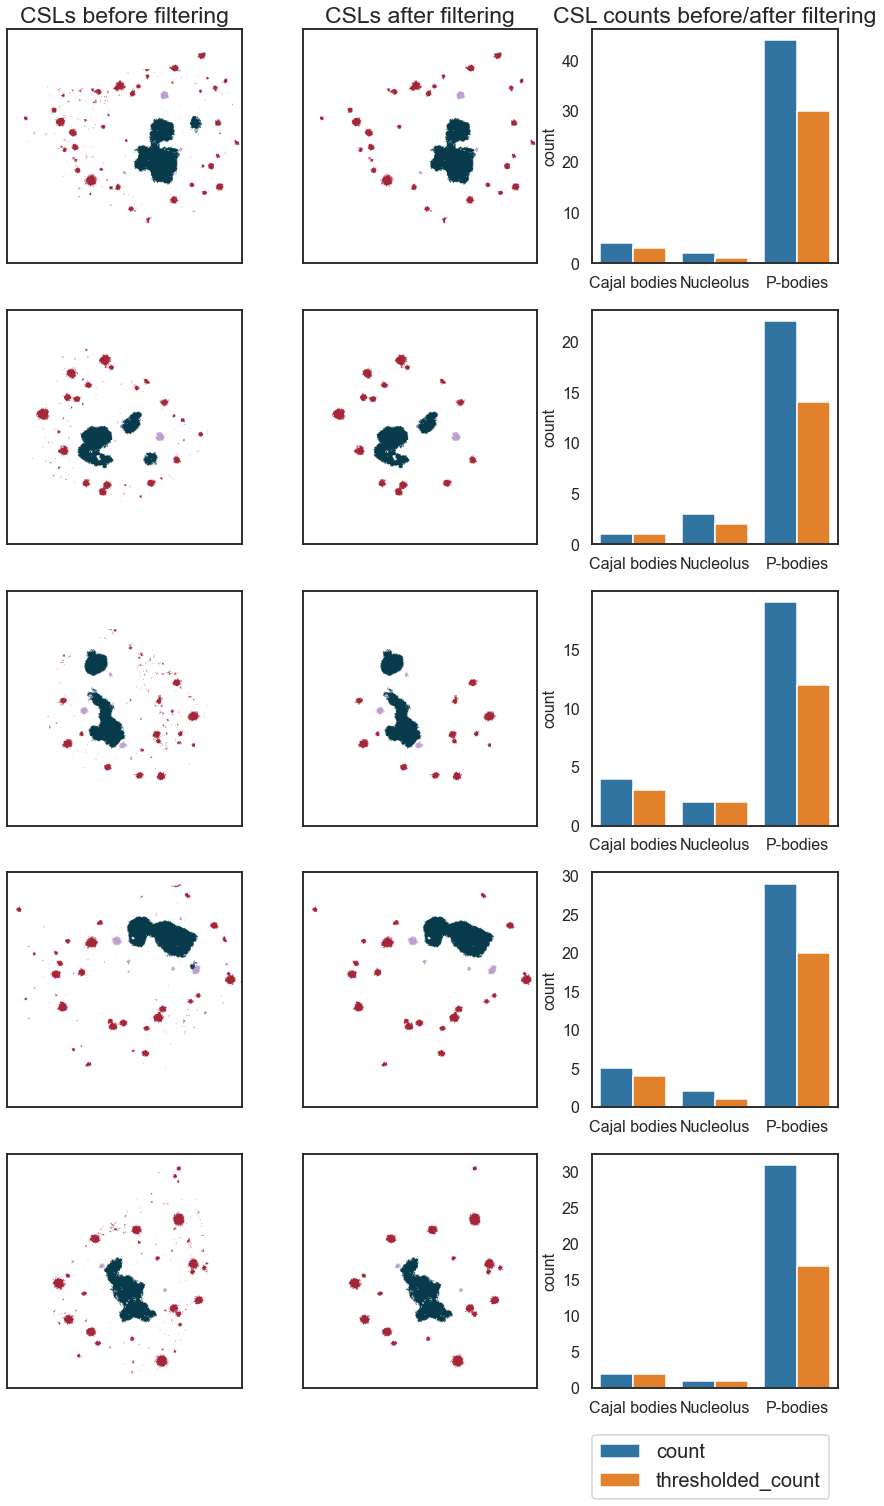

In [14]:
img_size = 400

# plot cajal bodies, nucleolus, and p-bodies
fig, axes = plt.subplots(num_cells,3, figsize=(15, num_cells*5), squeeze=False)
for i, obj_id in enumerate(selected_cells):
    cluster_img_colored = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation', 'color':True}, img_size=img_size)
    cluster_img = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation'}, img_size=img_size)
    cluster_img_masked = np.copy(cluster_img_colored)
    cluster_img_masked[~np.in1d(cluster_img, ['Cajal bodies', 'Nucleolus', 'P-bodies']).reshape(img_size,img_size)] = [255,255,255]

    # get thresholded information
    counts = {}
    for cl in ['Cajal bodies', 'Nucleolus', 'P-bodies']:
        mask = (object_stats['mapobject_id'] == int(obj_id)) & (object_stats['clustering'] == cl) & (object_stats['area'] > 10)
        object_mask = _thresholded_mask(object_stats[mask]['area'], threshold=0.9)
        min_size = object_stats[mask]['area'][object_mask].min()
        counts[cl] = {'min_size': min_size, 'count': len(object_stats[mask]), 
            'thresholded_count': len(object_stats[mask]['area'][object_mask])}

    # build thresholded image
    # get label image for filtering small objects
    cluster_names = {n: i for i, n in enumerate(extr.clusters + [""])}
    # convert labels to numbers
    img = np.vectorize(cluster_names.__getitem__)(cluster_img[:, :, 0])
    label_img = label(img, background=len(extr.clusters), connectivity=2)

    thresh_cluster_img = np.full((img_size,img_size), fill_value="", dtype=object)
    # iterate over all regions in this image
    for region in regionprops(label_img, intensity_image=img[:,:,np.newaxis]):
        # filter out single pixel regions, they cause problems in elongation and circularity calculation
        if region.area > 1:
            # get cluster label for this region
            assert region.min_intensity[0] == region.max_intensity[0]
            c = int(region.min_intensity[0])
            cluster = (extr.clusters + [""])[c]
            for cl in ['Cajal bodies', 'Nucleolus', 'P-bodies']:
                if cluster == cl and region.area >= counts[cl]['min_size']:
                    # is a selected cluster
                    thresh_cluster_img[region.coords[:,0], region.coords[:,1]] = cl
    thresh_cluster_img_colored = annotate_img(thresh_cluster_img, extr.annotation, from_col='annotation', color=True)

    # plot
    axes[i,0].imshow(cluster_img_masked)
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,1].imshow(thresh_cluster_img_colored)
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

    df = pd.melt(pd.DataFrame(counts).T.reset_index(), id_vars='index', value_vars=['count', 'thresholded_count'])
    df = df.rename(columns={'index':'CSL', 'value': 'count'})
    sns.barplot(data=df, y='count', hue='variable', x='CSL', ax=axes[i,2])
    axes[i,2].legend_.remove()
    axes[i,2].set_xlabel('')
    axes[i,2].set_ylabel('count', fontsize=16)
    axes[i,2].tick_params(axis='both', which='major', labelsize=16)
   
axes[0,0].set_title('CSLs before filtering', fontsize=23)
axes[0,1].set_title('CSLs after filtering', fontsize=23)
axes[0,2].set_title('CSL counts before/after filtering', fontsize=23)

plt.legend(bbox_to_anchor=(0, -0.2), loc='upper left', borderaxespad=0, prop={'size': 20})

plt.savefig(fig_dir/'suppl_example_cells_scrambled_K19.pdf', dpi=200, bbox_inches='tight')

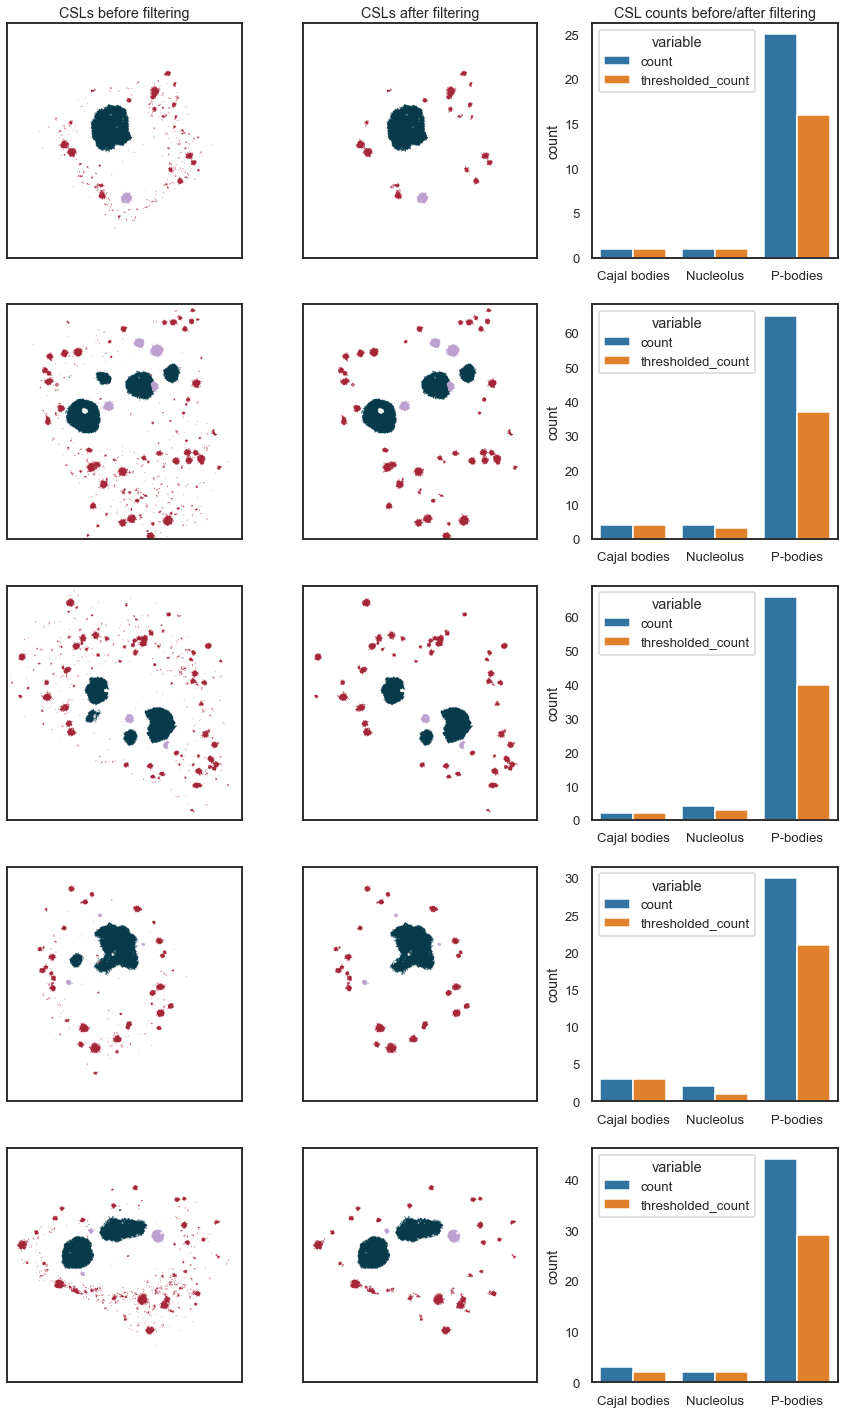

In [8]:
img_size = 400
# plot cajal bodies, nucleolus, and p-bodies
fig, axes = plt.subplots(num_cells,3, figsize=(15, num_cells*5), squeeze=False)
for i, obj_id in enumerate(selected_cells):
    cluster_img_colored = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation', 'color':True}, img_size=img_size)
    cluster_img = mpp_data.get_object_img(int(obj_id), data='clustering_res0.9_sub-0.33_seed3', annotation_kwargs={'annotation': extr.annotation, 'to_col': 'annotation'}, img_size=img_size)
    cluster_img_masked = np.copy(cluster_img_colored)
    cluster_img_masked[~np.in1d(cluster_img, ['Cajal bodies', 'Nucleolus', 'P-bodies']).reshape(img_size,img_size)] = [255,255,255]

    # get thresholded information
    counts = {}
    for cl in ['Cajal bodies', 'Nucleolus', 'P-bodies']:
        mask = (object_stats['mapobject_id'] == int(obj_id)) & (object_stats['clustering'] == cl) & (object_stats['area'] > 10)
        object_mask = _thresholded_mask(object_stats[mask]['area'], threshold=0.9)
        min_size = object_stats[mask]['area'][object_mask].min()
        counts[cl] = {'min_size': min_size, 'count': len(object_stats[mask]), 
            'thresholded_count': len(object_stats[mask]['area'][object_mask])}

    # build thresholded image
    # get label image for filtering small objects
    cluster_names = {n: i for i, n in enumerate(extr.clusters + [""])}
    # convert labels to numbers
    img = np.vectorize(cluster_names.__getitem__)(cluster_img[:, :, 0])
    label_img = label(img, background=len(extr.clusters), connectivity=2)

    thresh_cluster_img = np.full((img_size,img_size), fill_value="", dtype=object)
    # iterate over all regions in this image
    for region in regionprops(label_img, intensity_image=img[:,:,np.newaxis]):
        # filter out single pixel regions, they cause problems in elongation and circularity calculation
        if region.area > 1:
            # get cluster label for this region
            assert region.min_intensity[0] == region.max_intensity[0]
            c = int(region.min_intensity[0])
            cluster = (extr.clusters + [""])[c]
            for cl in ['Cajal bodies', 'Nucleolus', 'P-bodies']:
                if cluster == cl and region.area >= counts[cl]['min_size']:
                    # is a selected cluster
                    thresh_cluster_img[region.coords[:,0], region.coords[:,1]] = cl
    thresh_cluster_img_colored = annotate_img(thresh_cluster_img, extr.annotation, from_col='annotation', color=True)

    # plot
    axes[i,0].imshow(cluster_img_masked)
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,1].imshow(thresh_cluster_img_colored)
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

    df = pd.melt(pd.DataFrame(counts).T.reset_index(), id_vars='index', value_vars=['count', 'thresholded_count'])
    df = df.rename(columns={'index':'CSL', 'value': 'count'})
    sns.barplot(data=df, y='count', hue='variable', x='CSL', ax=axes[i,2])
    axes[i,2].set_xlabel('')
   
axes[0,0].set_title('CSLs before filtering')
axes[0,1].set_title('CSLs after filtering')
axes[0,2].set_title('CSL counts before/after filtering')

plt.savefig(fig_dir/'suppl_example_cells_scrambled_K19.png', dpi=200, bbox_inches='tight')

In [7]:
from copy import copy

def plot_object_stats(adata, group_key, features=None, clusters=None, figsize_mult=(2, 2), **kwargs):
    """Compare objects stats of groups in group_key.

    Uses stats in adata.obsm['object_stats_agg'], resulting from calling extr.get_object_stats()
    Args:
        adata: anndata object with 'object_stats_agg' in obsm
        group_key: categorical value in adata.obs to group by
        features: list of features to display. Must be columns of adata.obsm['object_stats_agg'].
            If None, all features are displayed.
        clusters: list of clusters to display. Must be columns of adata.obsm['object_stats_agg'].
            If None, all clusters are displayed.
        kwargs: passed to sns.boxplot
    """
    agg_stats = deepcopy(adata.obsm["object_stats_agg"])
    if not isinstance(agg_stats.columns, pd.MultiIndex):
        # restore multiindex for easier access
        agg_stats.columns = pd.MultiIndex.from_tuples([tuple(i.split("|")) for i in agg_stats.columns])
    if features is None:
        features = agg_stats.columns.levels[0]
    if clusters is None:
        clusters = agg_stats.columns.levels[1]
    fig, axes = plt.subplots(
        len(clusters),
        len(features),
        figsize=(len(features) * figsize_mult[0], len(clusters) * figsize_mult[1]),
        sharex=True,
        squeeze=False,
    )
    for i, row in enumerate(axes):
        for j, ax in enumerate(row):
            cluster = clusters[i]
            feature = features[j]
            df = copy(agg_stats[feature])
            df[group_key] = adata.obs[group_key]
            sns.boxplot(data=df, y=cluster, x=group_key, ax=ax, **kwargs)
            ax.set_title(feature)
    plt.tight_layout()

## Plot number of cajal bodies before / after filtering
read data from exported csv

In [15]:
# combined adatas for plotting
adata_object_stats = ad.concat([extr.adata for extr in extrs.values()], index_unique='-', uns_merge='same')

In [16]:
# read agg stats
agg_stats = []
for extr in extrs.values():
    fname = os.path.join(os.path.dirname(extr.fname), 'export', 'object_stats_features_seed3_annotation.csv')
    agg_stats.append(pd.read_csv(fname, index_col=0).set_index('mapobject_id'))
agg_stats = pd.concat(agg_stats)
agg_stats.index = agg_stats.index.astype(str)
#agg_stats.columns = pd.MultiIndex.from_tuples([tuple(i.split("|")) for i in agg_stats.columns])
agg_stats['siRNA'] = adata_object_stats.obs.set_index('mapobject_id')['siRNA']

In [17]:
order = np.random.permutation(np.arange(len(agg_stats)))

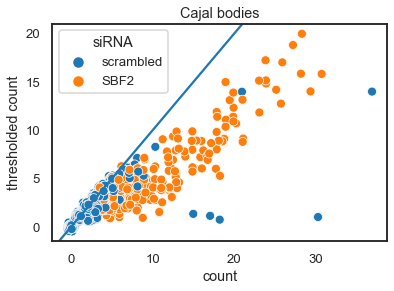

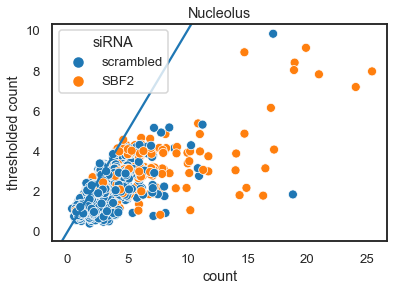

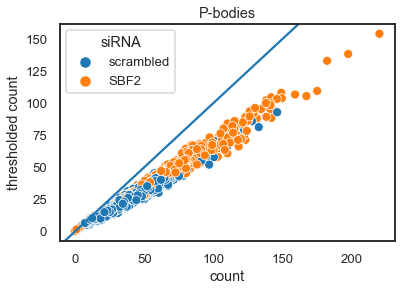

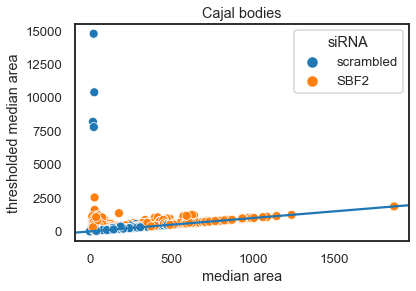

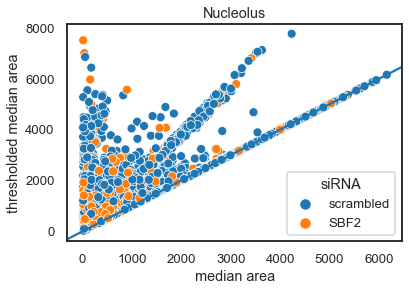

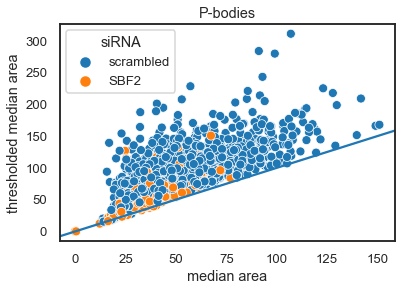

In [18]:
def jitter(values,j=0):
    return values + np.random.normal(j,0.2,values.shape)

order = np.random.permutation(np.arange(len(agg_stats)))
agg_stats = agg_stats.iloc[order]

for cluster in ['Cajal bodies', 'Nucleolus', 'P-bodies']:
    plt.figure()
    sns.scatterplot(x=jitter(agg_stats[f"count|{cluster}"]), y=jitter(agg_stats[f'area_thresholded_count|{cluster}']), hue=agg_stats['siRNA'])
    plt.axline((0,0), slope=1)
    plt.ylabel('thresholded count')
    plt.xlabel('count')
    plt.title(cluster)
    plt.savefig(fig_dir/f'suppl_scatter_counts_{cluster}.pdf', dpi=200, bbox_inches='tight')

for cluster in ['Cajal bodies', 'Nucleolus', 'P-bodies']:
    plt.figure()
    sns.scatterplot(x=jitter(agg_stats[f"area_median|{cluster}"]), y=jitter(agg_stats[f'area_thresholded_median|{cluster}']), hue=agg_stats['siRNA'])
    plt.axline((0,0), slope=1)
    plt.ylabel('thresholded median area')
    plt.xlabel('median area')
    plt.title(cluster)
    plt.savefig(fig_dir/f'suppl_scatter_area_{cluster}.pdf', dpi=200, bbox_inches='tight')


In [54]:
agg_stats

,area_median|Antibody aggregates,area_median|Cajal bodies,area_median|Cell-cell contacts,area_median|Cytoplasm,area_median|ER (perinuclear),area_median|ER (peripheral),area_median|Focal adhesions,area_median|Golgi apparatus,area_median|HDAC3 foci,area_median|Mitochondria (peripheral),...,mean_21_NCL_thresholded_median|Nuclear periphery,mean_21_NCL_thresholded_median|Nuclear speckles,mean_21_NCL_thresholded_median|Nucleolus,mean_21_NCL_thresholded_median|Nucleoplasm,mean_21_NCL_thresholded_median|P-bodies,mean_21_NCL_thresholded_median|PML bodies,well_name,perturbation_duration,TR,siRNA
mapobject_id,,,,,,,,,,,,,,,,,,,,,
193431,0.0,44.0,20.0,24.0,20.0,16.0,25.0,18.0,19.5,21.0,...,0.142372,0.453064,1.581997,0.445872,0.031962,0.485943,K18,normal,149.609183,SBF2
193432,0.0,490.5,12.0,22.0,21.0,19.5,31.0,42.5,12.0,24.0,...,0.099701,0.224026,1.719844,0.175891,0.028334,0.037405,K18,normal,166.452239,SBF2
193434,0.0,590.5,21.0,23.5,21.0,17.5,56.0,17.0,13.0,18.5,...,0.175075,0.223739,1.785589,0.243408,0.027716,0.859408,K18,normal,148.856837,SBF2
193436,0.0,632.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.143099,0.189950,1.609240,0.180000,0.056198,0.196905,K18,normal,316.111642,SBF2
193728,0.0,37.0,19.0,24.0,25.0,18.0,27.0,18.0,16.0,24.0,...,0.068752,0.359893,2.146900,0.348685,0.026636,0.382989,K18,normal,135.391267,SBF2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374233,0.0,88.0,19.0,29.5,22.0,13.0,20.5,2740.0,15.0,23.5,...,0.235276,0.072947,0.659125,0.100288,0.028539,0.127047,L18,normal,200.393572,scrambled
374235,0.0,98.0,26.0,21.5,18.0,0.0,16.0,29.0,0.0,20.0,...,0.259418,0.101270,0.676427,0.123320,0.039182,0.072403,L18,normal,271.700578,scrambled
374236,0.0,100.0,23.0,24.5,22.5,13.5,23.0,23.5,18.0,18.0,...,0.178079,0.127114,0.720245,0.144986,0.033970,0.106079,L18,normal,177.904809,scrambled


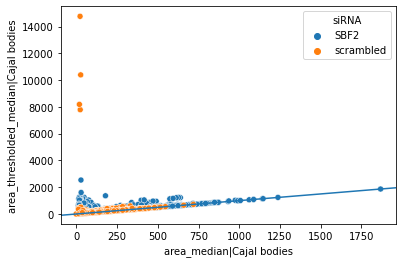

In [55]:
def jitter(values,j=0):
    return values + np.random.normal(j,0.2,values.shape)

sns.scatterplot(x=jitter(agg_stats["area_median|Cajal bodies"]), y=jitter(agg_stats['area_thresholded_median|Cajal bodies']), hue=agg_stats['siRNA'])
#g = sns.kdeplot(data=agg_stats, x="count|Cajal bodies", y='area_thresholded_count|Cajal bodies', hue='siRNA')
#g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
plt.axline((0,0), slope=1)